# Imports

In [1]:
# Base imports
import os

# Mathematical imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Environment
import gym
import gym_env

# Algorithms
from stable_baselines3 import TD3, A2C, DDPG, SAC, PPO, DQN, HerReplayBuffer

# Machine learning imports
from sklearn.metrics import confusion_matrix, accuracy_score

# Nbimporter allows to import from other files in jupyter notebook
import nbimporter
from lib import *

# Matplotlib settings
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

# Setting const variables

In [2]:
# Algorithms
algorithms = {
    "td3" : TD3,
    "a2c" : A2C,
    "ddpg" : DDPG,
    "sac" : SAC,
    "ppo" : PPO,
}

# Directory for training logs
log_dir = "tmp/"

# Reading data from csv

In [11]:
# Thermal data
df = pd.read_csv('../data/thm/processed_thermal_data.csv', index_col=0)

# EPS data
#df = pd.read_csv('../../data/eps/processed_test_power_measurements_2.csv')

# User settings
- episode_length is the max number of steps that the agent can correlate
- obs_size is the number of time steps that the agent observes
- train_timesteps is the number of time steps that training is going for
- predict_iter is the number of time steps that have to be predicted

In [23]:
# Choosing the parameter or multiple parameters (not yet implemented)
columns = ["B1_temp"]

# Choosing the number of models to use for prediction using Deep Ensembles
# Be carefull that there are enough models trained
models_num = 5

# Choosing appropriate algorithm
algorithm_name = "ddpg"
algorithm = algorithms[algorithm_name]

# Training parameters
predict_iter = 10000
episode_length = 100 # needed for environment setup and to find the correct model
obs_size = 1 # needed for environment setup and to find the correct model

# Data pre-processing

In [24]:
# Extracting the latest number of data points
# Total number of data points = 110000
# Data points are used for training = 100000
# Preferably to use predict_iter <= 10000 = (110000 - 100000)
df = df.iloc[-predict_iter:]

# Finds anomalies by setting a threshold to use as a reference for accuracy calculation
df = find_anomalies(df, columns)

#data reshaping
data_pre = df[columns].values
data = data_pre.reshape((data_pre.shape[0],))

# Data is normalized within the environment again. !!!!!
# However, the normalizer is set in order to denormalized data after prediction !!!!!!
normalizer = Normalizer(data)

# Predicting for multiple agents

In [25]:
test_list = []
for j in range(1,models_num+1):
    # setup the environment
    env = gym.make("Anomaly-v4", data=data, episode_length=episode_length, obs_size=obs_size)
    obs = env.reset(force=True)
    # load the data
    model = algorithm.load(f'tmp/best_models/{algorithm_name}_models/{columns[0]}/OBS_{obs_size}/EL_{episode_length}/model_{j}', env=env)
    env.reset(force=True)
    # Create arrays to store data
    actions = np.zeros(predict_iter)
    observations = np.zeros(predict_iter)
    rewards = np.zeros(predict_iter)
    # predict for current model
    for i in range(predict_iter):
        action, _states = model.predict(obs)
        actions[i] = action
        obs, reward, done, info = env.step(action)
        observations[i] = obs[-1]
        rewards[i] = reward
        if done:
            obs = env.reset()
    env.close()
    # denormalize
    predicted = normalizer.denormalize(actions)
    #store in a dataframe
    df[f"Test_{j}"] = predicted
    test_list.append(f"Test_{j}")

# Calculate the normal distribution for every time step

In [27]:
df['Mean'] = df[test_list].mean(axis = 1)
df["STD"] = df[test_list].std(axis = 1)
df['Variance'] = df["STD"]**2
df["Upper_boundary"] = df['Mean'] + df["STD"]
df["Lower_boundary"] = df['Mean'] - df["STD"]
#df_tmp["Anomalies"] = ((df_tmp["B1_temp"] >df_tmp["Upper_boundary"]) | (df_tmp["B1_temp"] <df_tmp["Lower_boundary"]))

# Plotting

### Plotting the distribution along the actual values

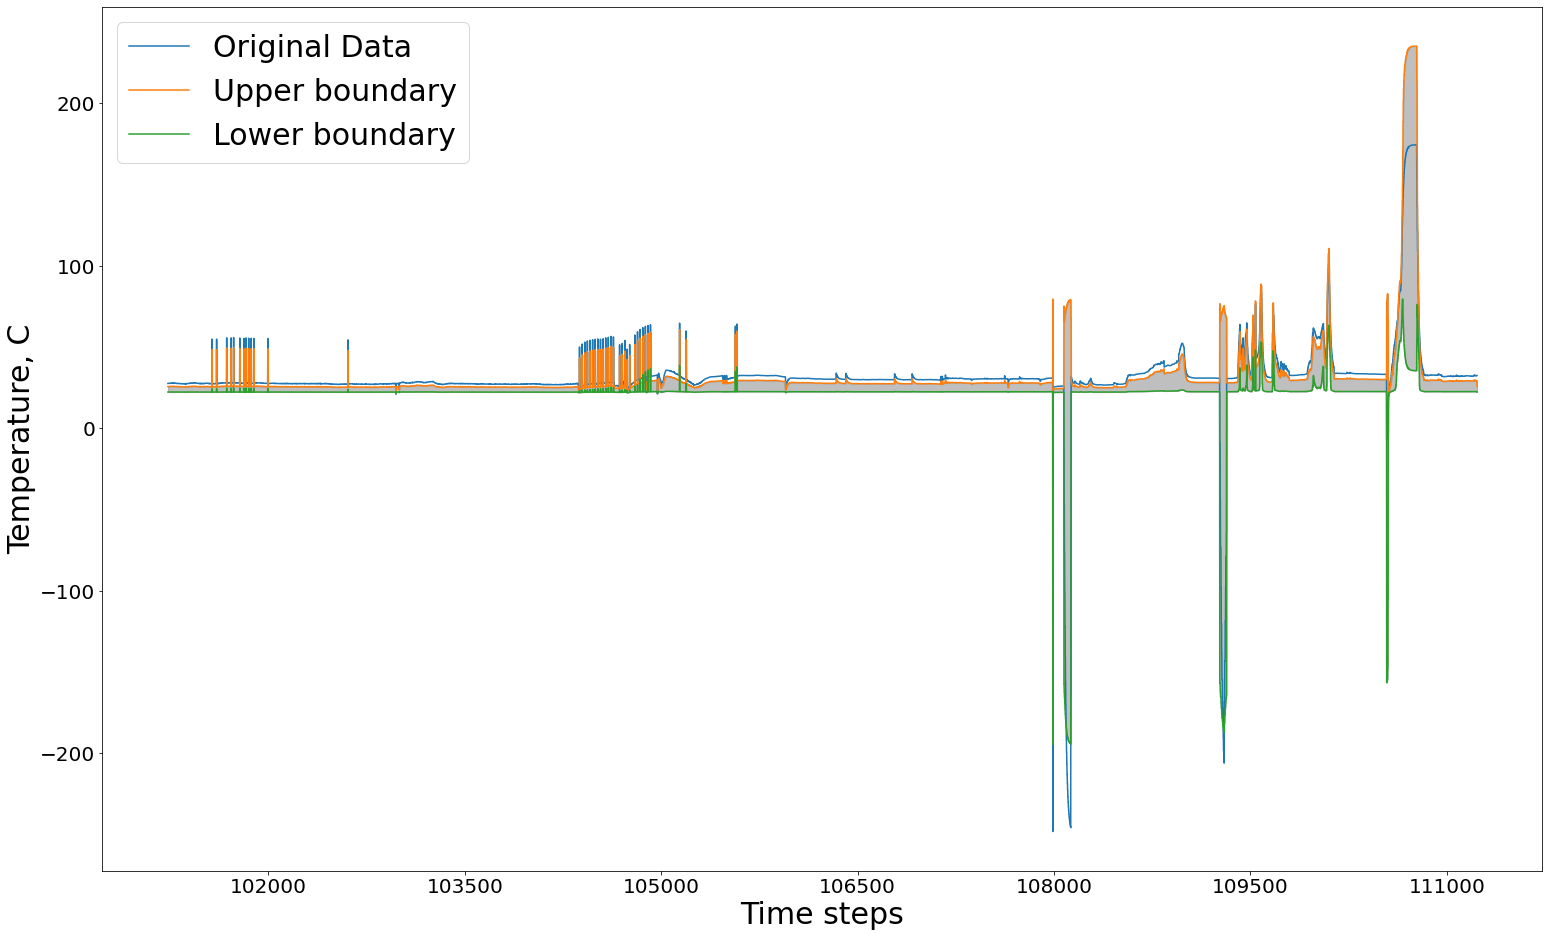

In [28]:
# Setting the figure up
fig = plt.figure(figsize =(25, 15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

# Plotting
ax.plot(df.index, df['B1_temp'], label="Original Data")
ax.plot(df.index, df["Upper_boundary"], label="Upper boundary")
ax.plot(df.index, df["Lower_boundary"], label="Lower boundary")
ax.fill_between(df.index, df["Upper_boundary"], df["Lower_boundary"], color='grey', alpha=0.5)
#ax.plot(df_plot["Anomalies"].index, df_plot["B1_temp"][df_plot["Anomalies"].index], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="Anomalies")

# Additional figure settings
ax.set_xlabel('Time steps', fontsize=30)
ax.set_ylabel('Temperature, C', fontsize=30)
#ax.set_xlim(0, 10000)
ax.legend(fontsize=30)
#fig.savefig(full_path, facecolor='white', transparent=False)
plt.show()
plt.close(fig)

### Plotting variance

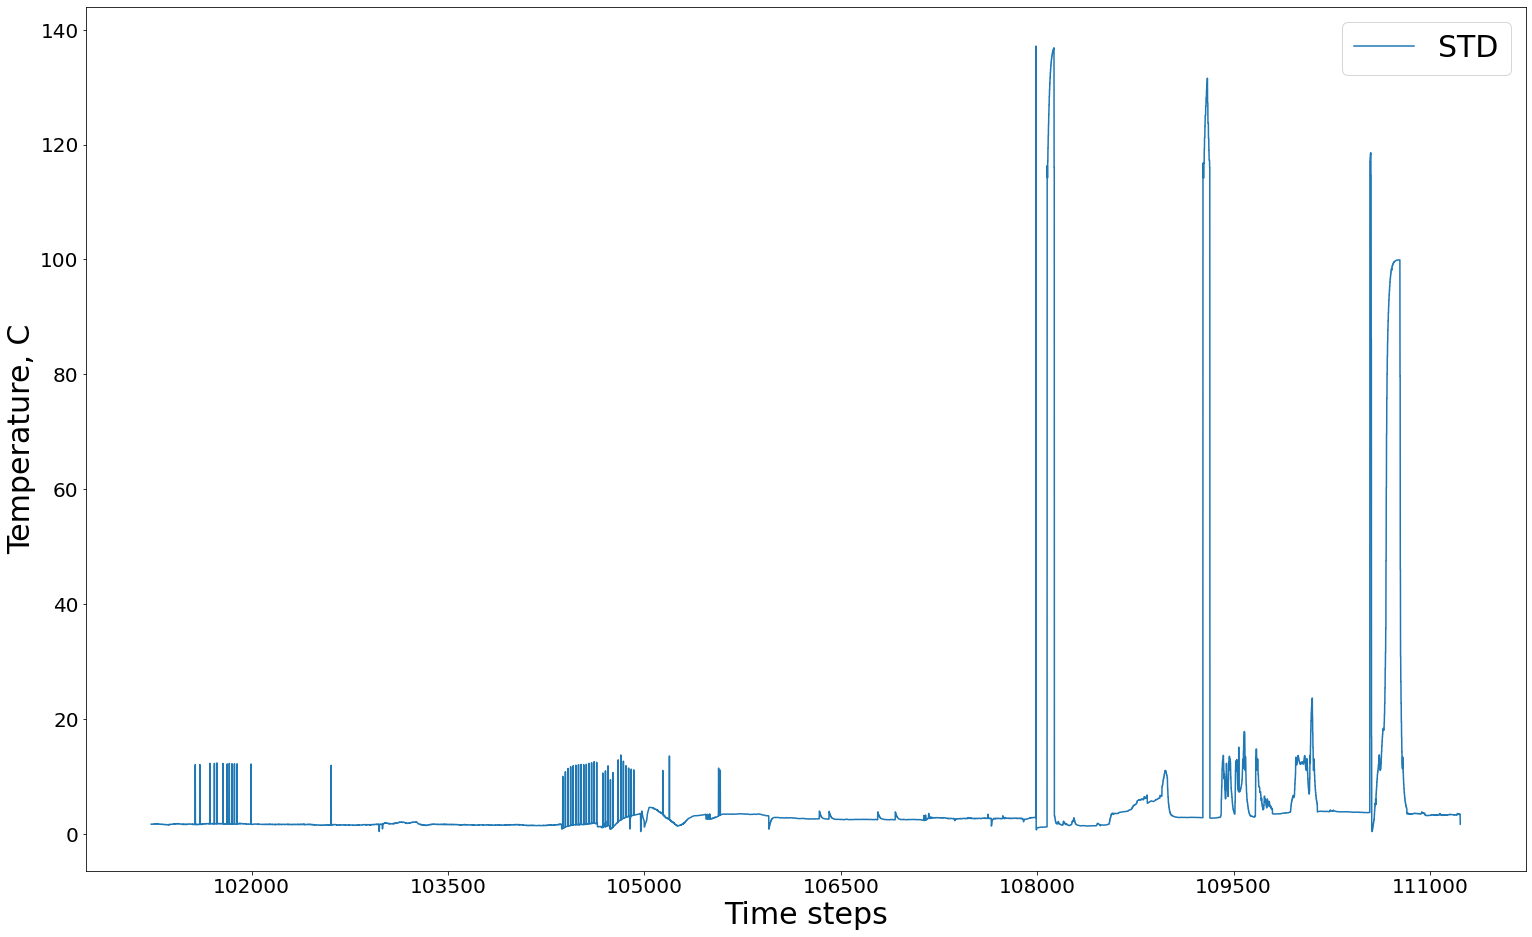

In [30]:
# Setting the figure up
fig = plt.figure(figsize =(25, 15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

# Plotting
ax.plot(df.index, df['STD'], label="STD")
#ax.plot(df_plot["Anomalies"].index, df_plot["STD"][df_plot["Anomalies"].index], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="Anomalies")

# Additional figure settings
ax.set_xlabel('Time steps', fontsize=30)
ax.set_ylabel('Temperature, C', fontsize=30)
#ax.set_xlim(0, 10000)
ax.legend(fontsize=30)
#fig.savefig(full_path, facecolor='white', transparent=False)
plt.show()